# **Imports**

Using Device:  cpu
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
Processing file: C:\Users\Sujal\Desktop\Traffic Detection Project\Traffic Detection Project\Traffic Detection Project\datasets\test\images\duque_de_caxias-45_png_jpg.rf.997aa3902d2810cec0ed0da3b6fdb4e0.jpg

0: 640x640 5 cars, 6 motorbikes, 210.8ms
Speed: 14.2ms preprocess, 210.8ms inference, 19.5ms postprocess per image at shape (1, 3, 640, 640)


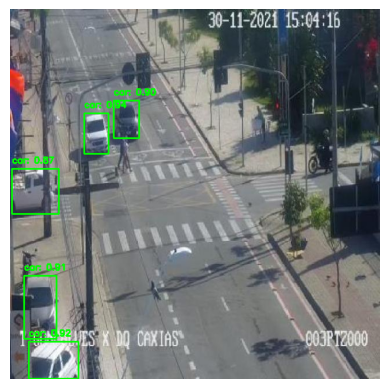

Number of vehicles detected: 5


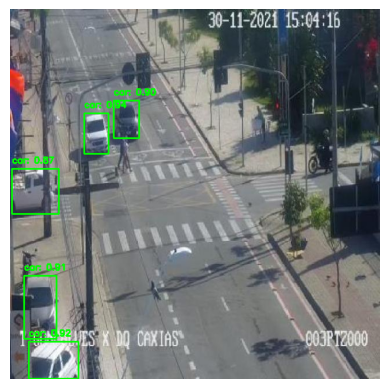

In [1]:
import os
import torch
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

class ObjectDetection:
    CUSTOM_CLASSES = ['bicycle', 'bus', 'car', 'motorbike', 'person']
    
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print("Using Device: ", self.device)
        self.model = self.load_model()
        
    def load_model(self):
        model = YOLO(r"C:\Users\Sujal\Desktop\Traffic Detection Project\Traffic Detection Project\Traffic Detection Project\runs\detect\train\weights\best.pt")
        model.fuse()
        return model
    
    def predict(self, image):
        results = self.model(image)
        return results
    
    def plot_bboxes(self, results, image):
        xyxys = []
        confidences = []
        class_ids = []

        for result in results:
            boxes = result.boxes.cpu().numpy()
            for box in boxes:
                xyxy = box.xyxy[0]
                conf = box.conf[0]
                cls = int(box.cls[0])

                # Filter for 'car' and 'motorbike' only
                if self.CUSTOM_CLASSES[cls] in ['car','bus','truck']:
                    xyxys.append(xyxy)
                    confidences.append(conf)
                    class_ids.append(cls)

                    cv2.rectangle(image, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
                    label = f"{self.CUSTOM_CLASSES[cls]}: {conf:.2f}"
                    cv2.putText(image, label, (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image_rgb, xyxys, confidences, class_ids
    
    def display_results(self, image_rgb):
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

# Instantiate the detector
detector = ObjectDetection()

# Directory containing images
images_dir = r"C:\Users\Sujal\Desktop\Traffic Detection Project\Traffic Detection Project\Traffic Detection Project\datasets\test\images"
images = os.listdir(images_dir)

# Select random images
random_images = random.sample(images,1)

for i, image_name in enumerate(random_images):
    image_path = os.path.join(images_dir, image_name)
    print(f"Processing file: {image_path}")  # Debugging line to check the path
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        continue
    image = Image.open(image_path)
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    results = detector.predict(image)
    image_rgb, xyxys, confidences, class_ids = detector.plot_bboxes(results, image)
    detector.display_results(image_rgb)
    vehicle_count = len(class_ids)
    print(f"Number of vehicles detected: {vehicle_count}")
    detector.display_results(image_rgb)


In [2]:
class TrafficSignalOptimizer:
    def __init__(self, green_light_min, green_light_max, saturation_flow_rate):
        self.green_light_min = green_light_min
        self.green_light_max = green_light_max
        self.saturation_flow_rate = saturation_flow_rate

    def calculate_green_light_duration(self, vehicle_count1):
        # Calculate green light duration based on vehicle count
        green_light_duration = vehicle_count / self.saturation_flow_rate
        # Ensure the green light duration is within the specified bounds
        green_light_duration = max(self.green_light_min, min(self.green_light_max, green_light_duration))
        return green_light_duration

# Example usage:
# Define parameters
green_light_min = 10  # Minimum green light duration in seconds
green_light_max = 60  # Maximum green light duration in seconds
saturation_flow_rate = 0.5  # Vehicles per second

# Initialize optimizer
optimizer = TrafficSignalOptimizer(green_light_min, green_light_max, saturation_flow_rate)

# Assuming you have already detected vehicles and have the count
vehicle_count1 = vehicle_count  # Example vehicle count, replace this with the actual count from the detection code
green_light_duration = optimizer.calculate_green_light_duration(vehicle_count1)
print(f"Suggested green light duration: {green_light_duration} seconds")


Suggested green light duration: 10 seconds


In [3]:
import tkinter as tk


In [4]:
import os
import tkinter as tk  # Ensure tkinter is imported correctly
import time
import torch
import cv2
from ultralytics import YOLO
import numpy as np
from threading import Thread
from multiprocessing.pool import ThreadPool

class ObjectDetection:
    CUSTOM_CLASSES = ['bicycle', 'bus', 'car', 'motorbike', 'person']
    
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = self.load_model()
        
    def load_model(self):
        model = YOLO(r"C:\Users\Sujal\Desktop\Traffic Detection Project\Traffic Detection Project\Traffic Detection Project\runs\detect\train\weights\best.pt")
        model.fuse()
        return model
    
    def predict(self, frame):
        results = self.model(frame)
        return results
    
    def count_vehicles(self, results):
        class_ids = []
        for result in results:
            boxes = result.boxes.cpu().numpy()
            for box in boxes:
                cls = int(box.cls[0])
                if self.CUSTOM_CLASSES[cls] in ['car', 'bus', 'truck']:
                    class_ids.append(cls)
        return len(class_ids)

    def process_video(self, video_path, skip_frames=5):
        cap = cv2.VideoCapture(video_path)
        total_vehicle_count = 0
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % skip_frames != 0:
                continue

            # Resize the frame to speed up processing
            frame = cv2.resize(frame, (640, 480))
            
            results = self.predict(frame)
            vehicle_count = self.count_vehicles(results)
            total_vehicle_count += vehicle_count

        cap.release()
        return total_vehicle_count

class TrafficSignalOptimizer:
    def __init__(self, green_light_min, green_light_max, saturation_flow_rate):
        self.green_light_min = green_light_min
        self.green_light_max = green_light_max
        self.saturation_flow_rate = saturation_flow_rate

    def calculate_green_light_duration(self, vehicle_count):
        green_light_duration = vehicle_count / self.saturation_flow_rate
        green_light_duration = max(self.green_light_min, min(self.green_light_max, green_light_duration))
        return green_light_duration

class TrafficSignalGUI:
    def __init__(self, root, durations, vehicle_counts, videos_dir, video_files):
        self.root = root
        self.durations = durations
        self.vehicle_counts = vehicle_counts
        self.videos_dir = videos_dir
        self.video_files = video_files
        
        self.root.title("Traffic Signal Simulation")
        self.root.geometry("600x400")
        
        self.signals = []
        for i in range(4):
            frame = tk.Frame(root)
            frame.pack(pady=20)
            
            signal_label = tk.Label(frame, text=f"Signal {i+1}", font=('Helvetica', 20), bg='red', width=10)
            signal_label.pack(side=tk.LEFT, padx=10)
            
            timer_label = tk.Label(frame, text="", font=('Helvetica', 20))
            timer_label.pack(side=tk.LEFT, padx=10)

            vehicle_count_label = tk.Label(frame, text=f"Vehicles: {self.vehicle_counts[i]}", font=('Helvetica', 15))
            vehicle_count_label.pack(side=tk.LEFT, padx=10)
            
            self.signals.append((signal_label, timer_label, vehicle_count_label))
        
        self.start_simulation()

    def start_simulation(self):
        Thread(target=self.run_signals).start()

    def run_signals(self):
        while True:
            for i, duration in enumerate(self.durations):
                signal_label, timer_label, vehicle_count_label = self.signals[i]
                signal_label.config(bg='green')
                
                # Start playing video for this signal in a separate thread
                video_path = os.path.join(self.videos_dir, self.video_files[i])
                Thread(target=self.play_video, args=(video_path,)).start()
                
                for remaining in range(int(duration), 0, -1):
                    timer_label.config(text=f"{remaining}s")
                    self.root.update()
                    time.sleep(1)
                
                signal_label.config(bg='red')
                timer_label.config(text="")
                self.root.update()
                
                time.sleep(1)

    def play_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        
        # Define the dimensions for the smaller video window (e.g., 320x240)
        window_width, window_height = 320, 240

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Resize the video frame to a smaller dimension (e.g., 320x240)
            frame = cv2.resize(frame, (window_width, window_height))

            # Display the resized video frame
            cv2.imshow('Video Playback', frame)

            # Wait for 25ms between frames
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()

def process_all_videos(detector, videos_dir, videos, skip_frames=5):
    pool = ThreadPool(processes=4)
    results = []
    
    for video_name in videos:
        video_path = os.path.join(videos_dir, video_name)
        result = pool.apply_async(detector.process_video, (video_path, skip_frames))
        results.append(result)
    
    pool.close()
    pool.join()

    vehicle_counts = [result.get() for result in results]
    return vehicle_counts

# Initialize the object detection and traffic signal optimizer
detector = ObjectDetection()
optimizer = TrafficSignalOptimizer(green_light_min=10, green_light_max=30, saturation_flow_rate=1.0)

# Directory containing videos
videos_dir = r"C:\Users\Sujal\Desktop\Traffic Detection Project\Traffic Detection Project\Traffic Detection Project\videos"
videos = ['video1.mp4', 'video2.mp4', 'video3.mp4', 'video4.mp4']

# Calculate vehicle counts for each video
vehicle_counts = process_all_videos(detector, videos_dir, videos, skip_frames=5)

# Calculate green light durations for each signal based on vehicle counts
durations = [optimizer.calculate_green_light_duration(count) for count in vehicle_counts]

# Print the vehicle counts and durations for debugging
print("Vehicle Counts:", vehicle_counts)
print("Green Light Durations:", durations)

# Setup the GUI with vehicle counts and durations, and play respective videos
root = tk.Tk()
gui = TrafficSignalGUI(root, durations, vehicle_counts, videos_dir, videos)
root.mainloop()


YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs



Ultralytics YOLOv8.2.58  Python-3.11.4 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)

Ultralytics YOLOv8.2.58  Python-3.11.4 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
0: 480x640 (no detections), 265.5ms
Speed: 8.4ms preprocess, 265.5ms inference, 10.2ms postprocess per image at shape (1, 3, 480, 640)

YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
Ultralytics YOLOv8.2.58  Python-3.11.4 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
0: 480x640 (no detections), 290.3ms
Speed: 3.0ms preprocess, 290.3ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
0: 480x640 3 cars, 209.1ms
Speed: 5.7ms preprocess, 209.1ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)
YOLOv8n summary (fused): 168 layers, 3,006

Exception in thread Thread-23 (run_signals):
Traceback (most recent call last):
  File "c:\Program Files\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\Sujal\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Program Files\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Sujal\AppData\Local\Temp\ipykernel_7792\1239655789.py", line 115, in run_signals
  File "c:\Program Files\Python311\Lib\tkinter\__init__.py", line 1702, in configure
    return self._configure('configure', cnf, kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python311\Lib\tkinter\__init__.py", line 1692, in _configure
    self.tk.call(_flatten((self._w, cmd)) + self._options(cnf))
RuntimeError: main thread is not in main loop


In [1]:
import os
import tkinter as tk
import time
import torch
import cv2
from ultralytics import YOLO
import numpy as np
from threading import Thread
from multiprocessing.pool import ThreadPool
from PIL import Image, ImageTk

class ObjectDetection:
    CUSTOM_CLASSES = ['bicycle', 'bus', 'car', 'motorbike', 'person']
    
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = self.load_model()
        
    def load_model(self):
        model = YOLO(r"C:\Users\Sujal\Desktop\Traffic Detection Project\Traffic Detection Project\Traffic Detection Project\runs\detect\train\weights\best.pt")
        model.fuse()
        return model
    
    def predict(self, frame):
        results = self.model(frame)
        return results
    
    def count_vehicles(self, results):
        class_ids = []
        for result in results:
            boxes = result.boxes.cpu().numpy()
            for box in boxes:
                cls = int(box.cls[0])
                if self.CUSTOM_CLASSES[cls] in ['car', 'bus', 'truck']:
                    class_ids.append(cls)
        return len(class_ids)

    def process_video(self, video_path, skip_frames=5):
        cap = cv2.VideoCapture(video_path)
        total_vehicle_count = 0
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % skip_frames != 0:
                continue

            # Resize the frame to a smaller dimension to speed up processing
            frame = cv2.resize(frame, (320, 240))
            
            results = self.predict(frame)
            vehicle_count = self.count_vehicles(results)
            total_vehicle_count += vehicle_count

        cap.release()
        return total_vehicle_count

class TrafficSignalOptimizer:
    def __init__(self, green_light_min, green_light_max, saturation_flow_rate):
        self.green_light_min = green_light_min
        self.green_light_max = green_light_max
        self.saturation_flow_rate = saturation_flow_rate

    def calculate_green_light_duration(self, vehicle_count):
        green_light_duration = vehicle_count / self.saturation_flow_rate
        green_light_duration = max(self.green_light_min, min(self.green_light_max, green_light_duration))
        return green_light_duration

class TrafficSignalGUI:
    def __init__(self, root, durations, vehicle_counts, videos_dir, video_files):
        self.root = root
        self.durations = durations
        self.vehicle_counts = vehicle_counts
        self.videos_dir = videos_dir
        self.video_files = video_files
        
        self.root.title("Traffic Signal Simulation")
        self.root.geometry("800x600")

        # Create a scrollable frame
        self.canvas = tk.Canvas(self.root)
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.scrollbar = tk.Scrollbar(self.root, orient=tk.VERTICAL, command=self.canvas.yview)
        self.scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        self.canvas.bind('<Configure>', lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all")))

        # Create a frame inside the canvas for scrolling
        self.frame = tk.Frame(self.canvas)
        self.canvas.create_window((0, 0), window=self.frame, anchor='nw')

        self.signals = []
        self.video_labels = []

        for i in range(4):
            signal_frame = tk.Frame(self.frame)
            signal_frame.pack(pady=20)

            signal_label = tk.Label(signal_frame, text=f"Signal {i+1}", font=('Helvetica', 20), bg='red', width=10)
            signal_label.pack(side=tk.LEFT, padx=10)
            
            timer_label = tk.Label(signal_frame, text="", font=('Helvetica', 20))
            timer_label.pack(side=tk.LEFT, padx=10)

            vehicle_count_label = tk.Label(signal_frame, text=f"Vehicles: {self.vehicle_counts[i]}", font=('Helvetica', 15))
            vehicle_count_label.pack(side=tk.LEFT, padx=10)

            # Create a label to show the video in the same window
            video_label = tk.Label(self.frame)
            video_label.pack(pady=10)

            self.signals.append((signal_label, timer_label, vehicle_count_label))
            self.video_labels.append(video_label)
        
        self.start_simulation()

    def start_simulation(self):
        Thread(target=self.run_signals).start()

    def run_signals(self):
        for i, duration in enumerate(self.durations):
            signal_label, timer_label, vehicle_count_label = self.signals[i]
            signal_label.config(bg='green')
            
            # Play video for this signal in the same GUI window
            video_path = os.path.join(self.videos_dir, self.video_files[i])
            self.play_video(video_path, self.video_labels[i])
            
            for remaining in range(int(duration), 0, -1):
                timer_label.config(text=f"{remaining}s")
                self.root.update()
                time.sleep(1)
            
            signal_label.config(bg='red')
            timer_label.config(text="")
            self.root.update()
            
            time.sleep(1)

    def play_video(self, video_path, video_label):
        cap = cv2.VideoCapture(video_path)
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Resize the video frame to a smaller dimension (e.g., 320x240)
            frame = cv2.resize(frame, (320, 240))

            # Convert the frame to RGB (tkinter uses RGB format)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Convert frame to a format that tkinter can display
            img = Image.fromarray(frame)
            img_tk = ImageTk.PhotoImage(image=img)

            # Update the video label with the new frame
            video_label.config(image=img_tk)
            video_label.image = img_tk  # Keep a reference to avoid garbage collection

            # Update the GUI and wait for 25ms between frames
            self.root.update()
            time.sleep(0.025)
        
        cap.release()

def process_all_videos(detector, videos_dir, videos, skip_frames=5):
    pool = ThreadPool(processes=4)
    results = []
    
    for video_name in videos:
        video_path = os.path.join(videos_dir, video_name)
        result = pool.apply_async(detector.process_video, (video_path, skip_frames))
        results.append(result)
    
    pool.close()
    pool.join()

    vehicle_counts = [result.get() for result in results]
    return vehicle_counts

# Initialize the object detection and traffic signal optimizer
detector = ObjectDetection()
optimizer = TrafficSignalOptimizer(green_light_min=10, green_light_max=30, saturation_flow_rate=1.0)

# Directory containing videos
videos_dir = r"C:\Users\Sujal\Desktop\Traffic Detection Project\Traffic Detection Project\Traffic Detection Project\videos"
videos = ['video1.mp4', 'video2.mp4', 'video3.mp4', 'video4.mp4']

# Calculate vehicle counts for each video
vehicle_counts = process_all_videos(detector, videos_dir, videos, skip_frames=5)

# Calculate green light durations for each signal based on vehicle counts
durations = [optimizer.calculate_green_light_duration(count) for count in vehicle_counts]

# Print the vehicle counts and durations for debugging
print("Vehicle Counts:", vehicle_counts)
print("Green Light Durations:", durations)

# Setup the GUI with vehicle counts and durations, and play respective videos
root = tk.Tk()
gui = TrafficSignalGUI(root, durations, vehicle_counts, videos_dir, videos)
root.mainloop()


YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs



Ultralytics YOLOv8.2.58  Python-3.11.4 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
Ultralytics YOLOv8.2.58  Python-3.11.4 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
Ultralytics YOLOv8.2.58  Python-3.11.4 torch-2.3.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)

YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
0: 480x640 (no detections), 185.1ms
Speed: 10.1ms preprocess, 185.1ms inference, 14.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 139.6ms
Speed: 5.0ms preprocess, 139.6ms inference, 10.0ms postprocess per image at shape (1, 3, 480, 640)
0: 480x640 4 cars, 163.2ms
Speed: 3.5ms preprocess, 163.2ms inference, 0.7ms postprocess per